In [32]:
import os
from torch.utils.data import DataLoader
from dataloader_e2e import create_dataset_12
import matplotlib.pyplot as plt
from PIL import ImageOps
import torchvision
import numpy as np
import cv2

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import *


device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)
path = os.getcwd()
path = '/root/notebooks/sample/dataset/ECG100_224_new/'
train_dataloader,test_dataloader,label_lead, labels=create_dataset_12(path,1,None)



cuda:1
Classification lab : {'Lateral': 0, 'Posterior': 1, 'Anterior': 2, 'Inferior': 3, 'Normal': 4}
Number of datas 368
torch.Size([12, 368, 3, 112, 224])
368
368


In [33]:
# モデルクラス
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # 畳み込み層や全結合層などを定義する
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.faltten = nn.Flatten()
        self.fc1 = nn.Linear(16,16)
        self.fc2 = nn.Linear(16, 12)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.gap(x)
        x = self.faltten(x)
        #x = x.view(-1, 16 * 56 * 112)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# モデルのインスタンスを作成
model = CNNModel().to(device)


事前学習

In [34]:
# モデル訓練　事前学習12クラス分類

# 損失関数
criterion = nn.CrossEntropyLoss()

# 最適化アルゴリズム
optimizer = optim.Adam(model.parameters(), lr=0.0001)
bestscore = 1000.0
loss_list,loss_list_test = [], []
f1s, f1s_test = [],[]
acc, acc_test = [], []

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss, running_loss_test = 0.0, 0.0
    preds, label =[], []
    preds_test,label_test = [], []

    for ecg_image,labels,label_lead,patients,num_leads in train_dataloader:
        image =ecg_image.reshape(-1,3,112,224).to(device)
        
        label_lead = label_lead.reshape(-1).to(device)
        optimizer.zero_grad()  # 勾配を初期化
        
        outputs = model(image)  # モデルの出力を計算

        prob, pred=torch.max(outputs,1)
        preds.extend(pred.tolist())
        label.extend(label_lead.tolist())
        loss = criterion(outputs, label_lead)  # 損失を計算
        loss.backward()  # 勾配を計算
        optimizer.step()  # パラメータを更新

        running_loss += loss.item()


    for ecg_image,labels,label_lead,patients,num_leads in test_dataloader:
        image =ecg_image.reshape(-1,3,112,224).to(device)
        label_lead = label_lead.reshape(-1).to(device)

        outputs = model(image)  # モデルの出力を計算
        prob, pred=torch.max(outputs,1)
        preds_test.extend(pred.tolist())
        label_test.extend(label_lead.tolist())
        
        loss = criterion(outputs, label_lead)  # 損失を計算

        running_loss_test += loss.item()
    
    score = running_loss_test/len(test_dataloader)
    if score < bestscore:
        bestscore = score
        torch.save(model.state_dict(), '/root/notebooks/sample/models/bestmodel.pth')
        print('best score!!')
    loss_list.append(running_loss/len(train_dataloader))
    loss_list_test.append(running_loss_test/len(test_dataloader))
    f1 = f1_score(preds,label,average='macro')
    f1_test = f1_score(preds_test,label_test,average='macro')
    f1s.append(f1)
    f1s_test.append(f1_test)
    accuracy = accuracy_score(preds,label)
    accuracy_test = accuracy_score(preds_test,label_test)
    acc.append(accuracy)
    acc_test.append(accuracy_test)

    # 1エポック終了時の損失を表示
    print(f"Epoch [{epoch+1}/{num_epochs}] Train-Loss: {running_loss/len(train_dataloader)} Test-Loss: {running_loss_test/len(train_dataloader)} Train-f1: {f1} Test-f1: {f1_test} Train-acc: {accuracy} Test-acc: {accuracy_test}")

best score!!
Epoch [1/5] Train-Loss: 2.4936915344121506 Test-Loss: 0.6264473053873801 Train-f1: 0.012820512820512822 Test-f1: 0.012820512820512822 Train-acc: 0.08333333333333333 Test-acc: 0.08333333333333333
best score!!
Epoch [2/5] Train-Loss: 2.481623420099012 Test-Loss: 0.6215133691320613 Train-f1: 0.04146628130379213 Test-f1: 0.06824835127423035 Train-acc: 0.10345804988662131 Test-acc: 0.1463963963963964
best score!!
Epoch [3/5] Train-Loss: 2.4434404365059468 Test-Loss: 0.6072719786442867 Train-f1: 0.05471347172264119 Test-f1: 0.06408511005838591 Train-acc: 0.11734693877551021 Test-acc: 0.14864864864864866
best score!!
Epoch [4/5] Train-Loss: 2.3722778639825832 Test-Loss: 0.5897959276121489 Train-f1: 0.07140333996335513 Test-f1: 0.05975682676146581 Train-acc: 0.1578798185941043 Test-acc: 0.13626126126126126
best score!!
Epoch [5/5] Train-Loss: 2.3075912169047763 Test-Loss: 0.5785879723879755 Train-f1: 0.07969203842547908 Test-f1: 0.07610267832135607 Train-acc: 0.1556122448979592 Te

In [35]:
# モデル評価
pred,label = [],[]
model.load_state_dict(torch.load('/root/notebooks/sample/models/bestmodel.pth'))
model.eval()

for ecg_image,labels,label_lead,patients,num_leads in test_dataloader:
    image =ecg_image.reshape(-1,3,112,224).to(device)
    label_lead = label_lead.reshape(-1).to(device)
    label.extend(label_lead.tolist())
    outputs = model(image)  # モデルの出力を計算
    prob, preds=torch.max(outputs,1)
    pred.extend(preds.tolist())
    f1_test = f1_score(preds.tolist(),label_lead.tolist(),average='macro')
    
    loss = criterion(outputs, label_lead)  # 損失を計算

    running_loss_test += loss.item()

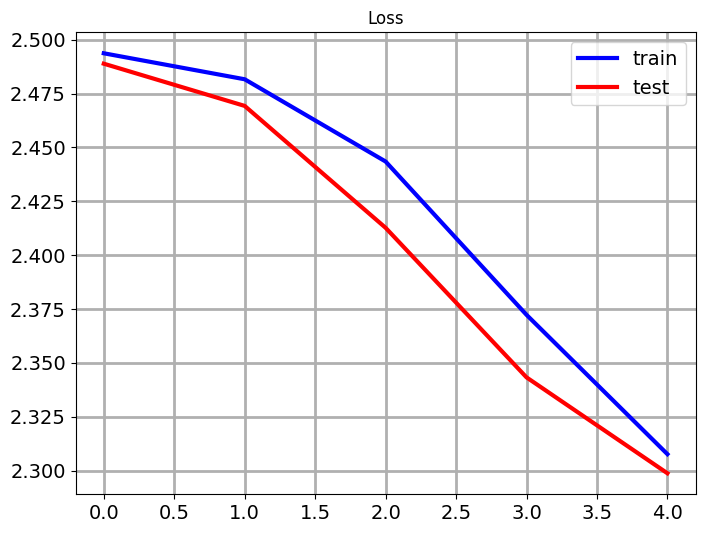

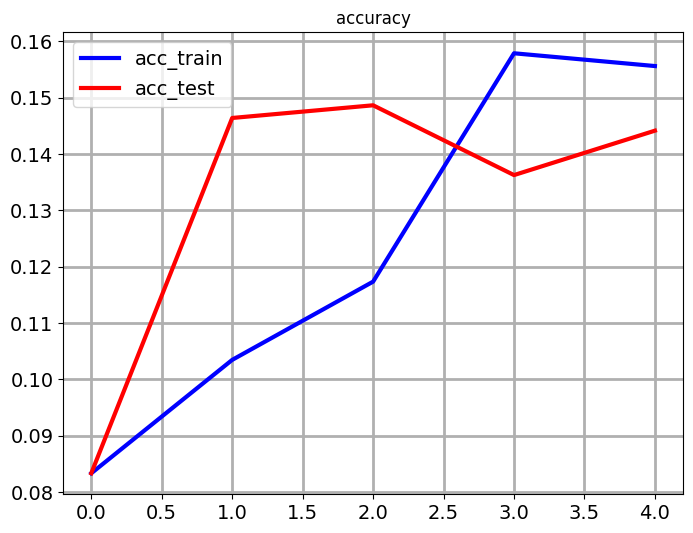

In [36]:
# 学習曲線 (損失関数) 事前学習
plt.figure(figsize=(8,6))
plt.plot(loss_list,label='train', lw=3, c='b')
plt.plot(loss_list_test,label='test', lw=3, c='r')
plt.title('Loss')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

# 学習曲線 (accuracy)
plt.figure(figsize=(8,6))
plt.plot(acc,label='acc_train', lw=3, c='b')
plt.plot(acc_test,label='acc_test', lw=3, c='r')
plt.title('accuracy')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()


Confusion matrix, without normalization
[[ 0 10  3  0 49  0  0  0  5  7  0  0]
 [ 0  6  9  0 38  0  1  0 10  8  2  0]
 [ 0  3  4  0 51  0  0  0  7  8  1  0]
 [ 0  0  4  0 64  0  0  0  6  0  0  0]
 [ 0  2  7  0 56  0  2  0  3  4  0  0]
 [ 0  5  6  0 50  0  2  0  4  6  1  0]
 [ 0  1  8  0 40  0  0  0 13 12  0  0]
 [ 0  4  6  0  6  0  1  0 17 40  0  0]
 [ 0  3  5  0  7  0  1  0 19 39  0  0]
 [ 0  2  3  0 10  0  0  0 16 41  2  0]
 [ 0  5  5  0 17  0  1  0 19 25  2  0]
 [ 0  7  6  0 30  0  5  0 12 12  2  0]]


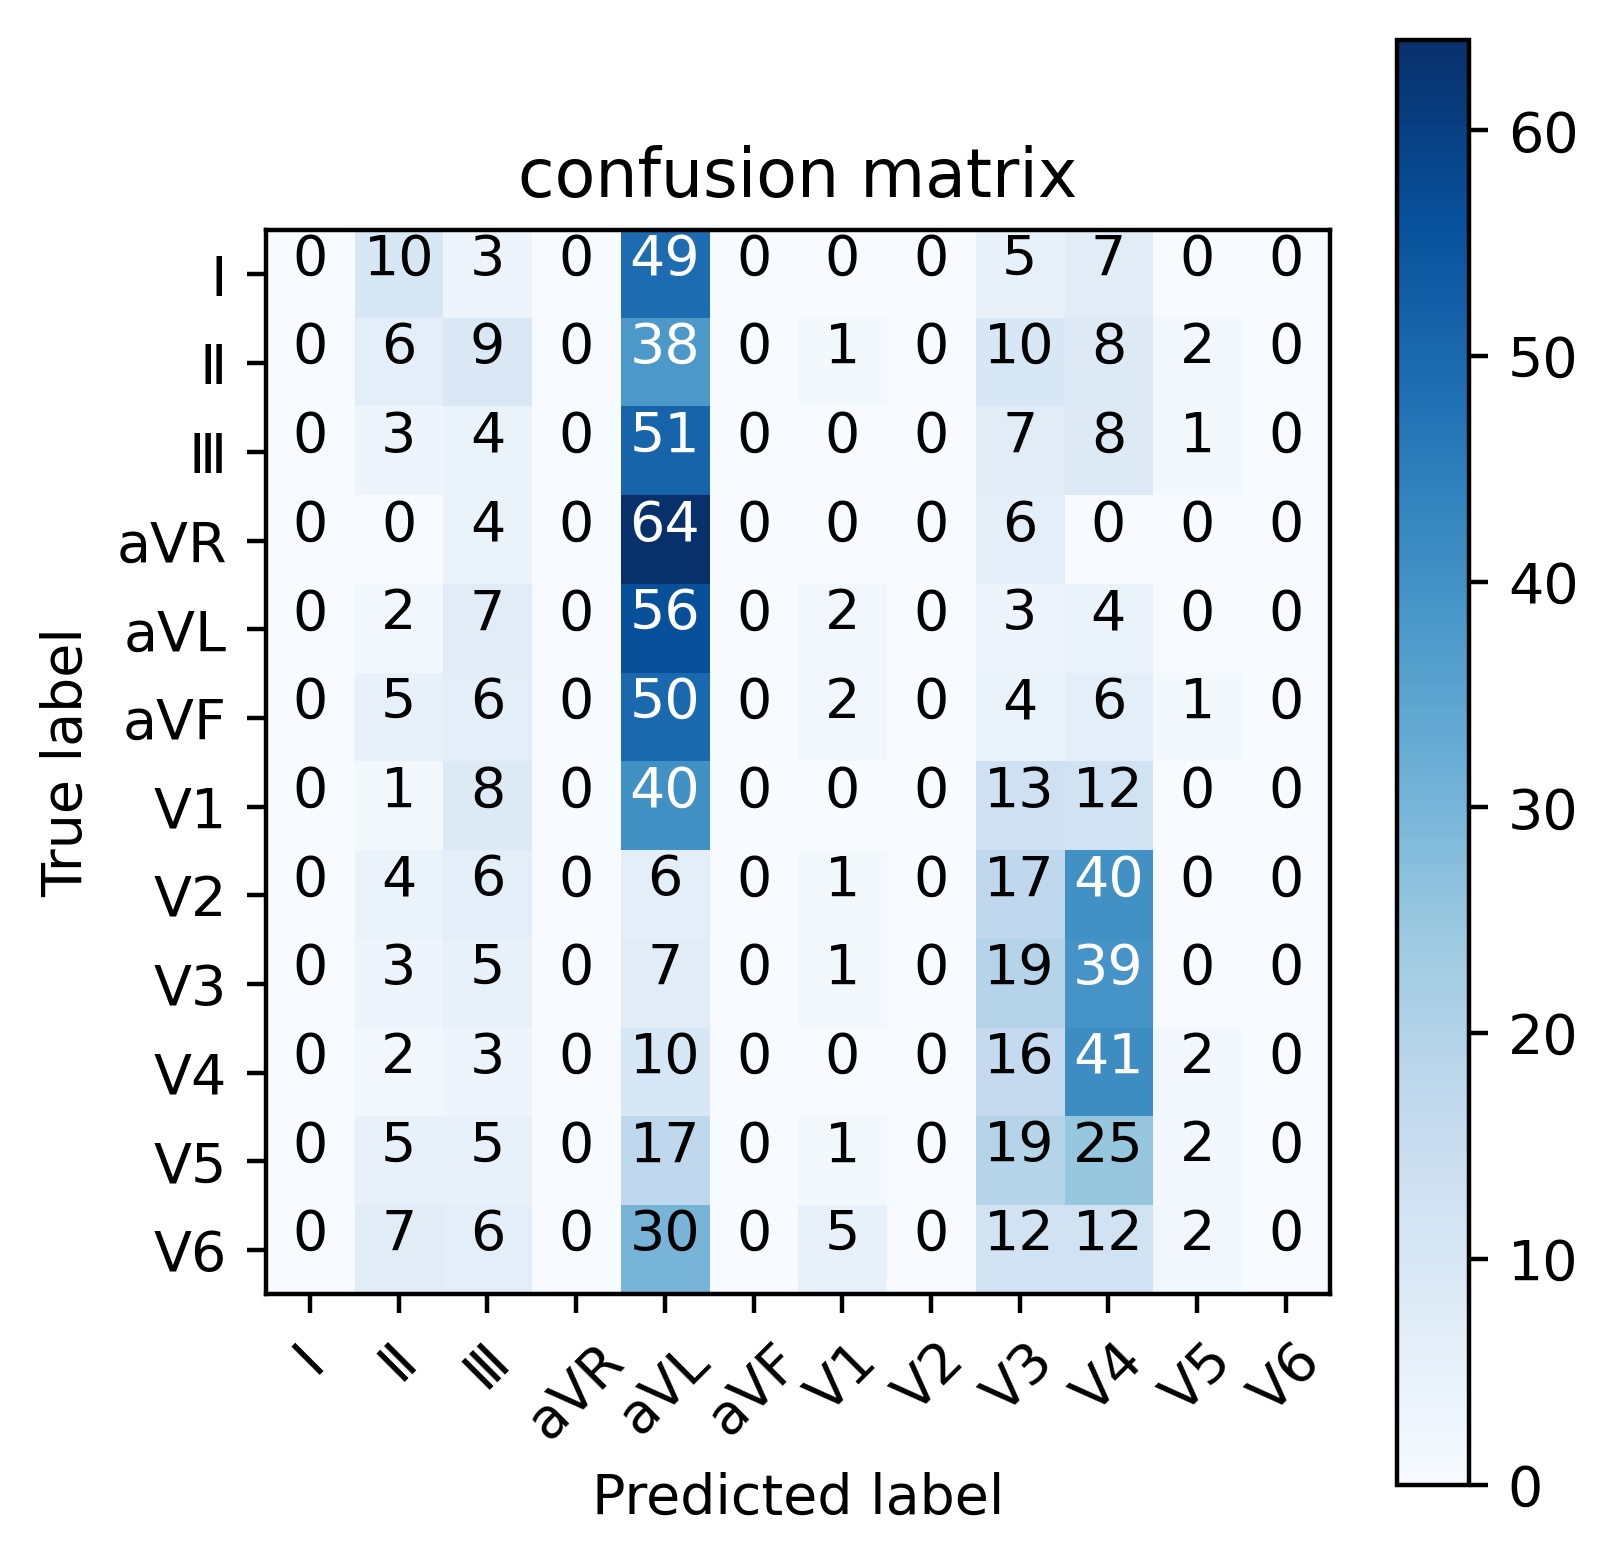

In [37]:
# Confusion matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
           """
           This function prints and plots the confusion matrix.
           Normalization can be applied by setting `normalize=True`.
           """
           if normalize:
               cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
               print("Normalized confusion matrix")
           else:
               print('Confusion matrix, without normalization')
           print(cm)
           plt.imshow(cm, interpolation='nearest', cmap=cmap)
           plt.title(title)
           plt.colorbar()
           tick_marks = np.arange(len(classes))
           plt.xticks(tick_marks, classes, rotation=45)
           plt.yticks(tick_marks, classes)
           fmt = '.2f' if normalize else 'd'
           thresh = cm.max() / 2.
           for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
               plt.text(j, i, format(cm[i, j], fmt),
                        horizontalalignment="center",
                        color="white" if cm[i, j] > thresh else "black")
           plt.tight_layout()
           plt.ylabel('True label')
           plt.xlabel('Predicted label')
           #plt.savefig(output_file)


labels=[0,1,2,3,4,5,6,7,8,9,10,11]
label2=['Ⅰ','Ⅱ','Ⅲ','aVR','aVL','aVF','V1', 'V2', 'V3', 'V4', 'V5','V6']
cnf_matrix=confusion_matrix(label,pred,labels=labels)
title="confusion matrix"
plt.figure(figsize=(4,4),dpi=400)
plot_confusion_matrix(cnf_matrix, classes=label2,title=title)
plt.show()

ファインチューニング

In [38]:
# CNNモデルの特徴抽出器を取り出す
feature_extractor = nn.Sequential(*list(model.children())[:-2])

# 新しい全結合層を追加
feature_extractor.to(device)
print(feature_extractor)


# カスタムレイヤーを定義
class MeanLayer(nn.Module):
    def forward(self, x):
        return torch.mean(x, dim=0, keepdim=True)

# nn.Sequential内にカスタムレイヤーを含むモデルを定義
CNN_diagnosis = nn.Sequential(
    feature_extractor,
    nn.Linear(16, 16),
    nn.Linear(16, 5),
    MeanLayer()  # カスタムレイヤーを追加
)

CNN_diagnosis.to(device)

print(CNN_diagnosis)

Sequential(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Flatten(start_dim=1, end_dim=-1)
)
Sequential(
  (0): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): AdaptiveAvgPool2d(output_size=1)
    (5): Flatten(start_dim=1, end_dim=-1)
  )
  (1): Linear(in_features=16, out_features=16, bias=True)
  (2): Linear(in_features=16, out_features=5, bias=True)
  (3): MeanLayer()
)


In [39]:
## 診断モデル

# 損失関数
criterion = nn.CrossEntropyLoss()


# 最適化アルゴリズム
optimizer = optim.Adam(CNN_diagnosis.parameters(), lr=0.0001)
bestscore_dx = 1000.0
loss_list_dx,loss_list_test_dx = [], []
f1s_dx, f1s_test_dx = [],[]
acc_dx, acc_test_dx = [], []

num_epochs_dx = 2

# モデル訓練　5クラス分類

for epoch in range(num_epochs_dx):
    CNN_diagnosis.train()
    running_loss_dx = 0.0
    preds_dx, label_dx = [], []
    running_loss_dx, running_loss_test_dx = 0.0, 0.0
    preds_test_dx,label_test_dx = [], []

    for ecg_image, labels, label_lead, patients, num_leads in train_dataloader:
        image = ecg_image.reshape(-1, 3, 112, 224).to(device)
        labels = labels.reshape(-1).to(device)  # ラベルを1次元に変形
        labels = labels.to(torch.long)  # CrossEntropyLossではクラスのインデックスはlong型である必要がある

        optimizer.zero_grad()  # 勾配を初期化

        outputs = CNN_diagnosis(image).to(torch.float64)  # モデルの出力を計算

        prob, pred = torch.max(outputs, 1)
        preds_dx.extend(pred.tolist())
        label_dx.extend(labels.tolist())

        loss = criterion(outputs, labels)  # 損失を計算（CrossEntropyLossの引数は予測とラベル）
        loss.backward()  # 勾配を計算
        optimizer.step()  # パラメータを更新

        running_loss_dx += loss.item()

    for ecg_image,labels,label_lead,patients,num_leads in test_dataloader:
        image =ecg_image.reshape(-1,3,112,224).to(device)
        labels = labels.reshape(-1).to(device)

        outputs = CNN_diagnosis(image)  # モデルの出力を計算
        outputs = outputs.to(torch.float64)
        prob, pred=torch.max(outputs,1)
        preds_test_dx.extend(pred.tolist())
        label_test_dx.extend(labels.tolist())
        
        #print(outputs)
        loss = criterion(outputs, labels)  # 損失を計算

        running_loss_test_dx += loss.item()
    
    score_dx = running_loss_test_dx/len(test_dataloader)
    if score_dx < bestscore_dx:
        bestscore_dx = score_dx
        torch.save(CNN_diagnosis.state_dict(), '/root/notebooks/sample/models/bestmodel_dx.pth')
        print('best score_dx!!')
    loss_list_dx.append(running_loss_dx/len(train_dataloader))
    loss_list_test_dx.append(running_loss_test_dx/len(test_dataloader))
    f1_dx = f1_score(preds_dx,label_dx,average='macro')
    f1_test_dx = f1_score(preds_test_dx,label_test_dx,average='macro')
    f1s_dx.append(f1_dx)
    f1s_test_dx.append(f1_test_dx)
    accuracy_dx = accuracy_score(preds_dx,label_dx)
    accuracy_test_dx = accuracy_score(preds_test_dx,label_test_dx)
    acc_dx.append(accuracy_dx)
    acc_test_dx.append(accuracy_test_dx)

    # 1エポック終了時の損失を表示
    print(f"Epoch [{epoch+1}/{num_epochs_dx}] Train-Loss: {running_loss_dx/len(train_dataloader)} Test-Loss: {running_loss_test_dx/len(train_dataloader)} Train-f1: {f1_dx} Test-f1: {f1_test_dx} Train-acc: {accuracy_dx} Test-acc: {accuracy_test_dx}")

best score_dx!!
Epoch [1/2] Train-Loss: 1.4482814335232224 Test-Loss: 0.33683042323165396 Train-f1: 0.1555059234802874 Test-f1: 0.12592592592592594 Train-acc: 0.3333333333333333 Test-acc: 0.4594594594594595
best score_dx!!
Epoch [2/2] Train-Loss: 1.3118726681978856 Test-Loss: 0.32580746965581975 Train-f1: 0.12651162790697673 Test-f1: 0.12592592592592594 Train-acc: 0.46258503401360546 Test-acc: 0.4594594594594595


In [40]:
# モデル評価 ５クラス診断
pred_dx,label_dx = [],[]
CNN_diagnosis.load_state_dict(torch.load('/root/notebooks/sample/models/bestmodel_dx.pth'))
CNN_diagnosis.eval()

for ecg_image,labels,label_lead,patients,num_leads in test_dataloader:
    image =ecg_image.reshape(-1,3,112,224).to(device)
    labels = labels.reshape(-1).to(device)
    label_dx.extend(labels.tolist())
    outputs = CNN_diagnosis(image)  # モデルの出力を計算
    prob_dx, preds_dx=torch.max(outputs,1)
    pred_dx.extend(preds_dx.tolist())
    f1_test_dx = f1_score(preds_dx.tolist(),labels.tolist(),average='macro')
    accuracy_test_dx = accuracy_score(preds_test_dx,label_test_dx)
    loss = criterion(outputs, labels)  # 損失を計算

    running_loss_test_dx += loss.item()


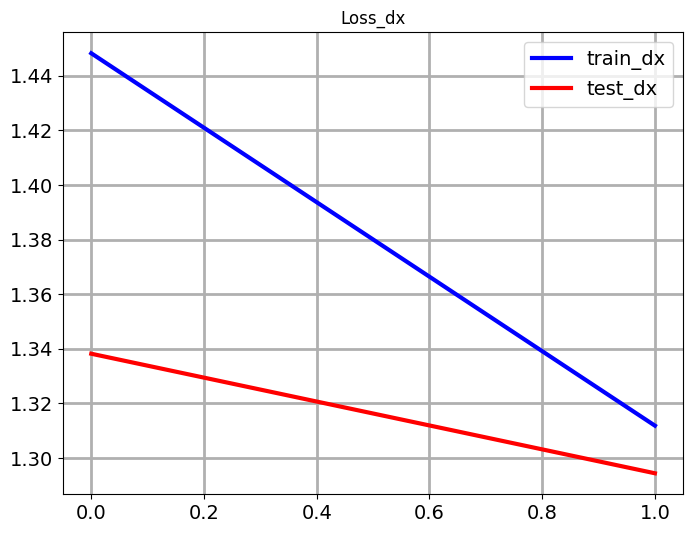

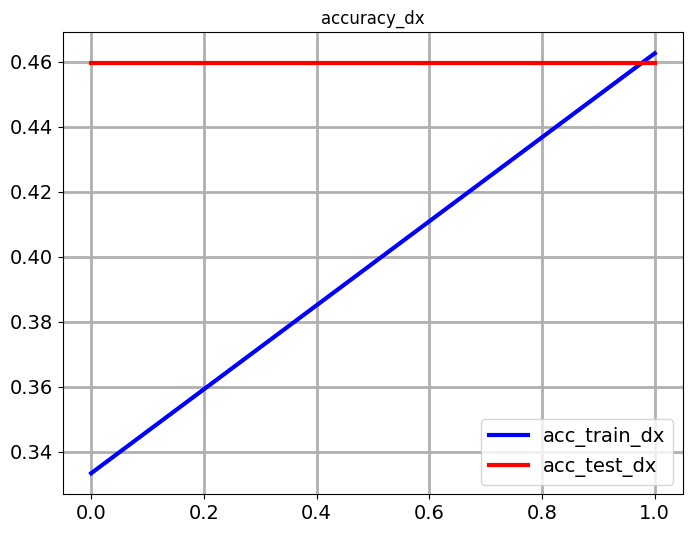

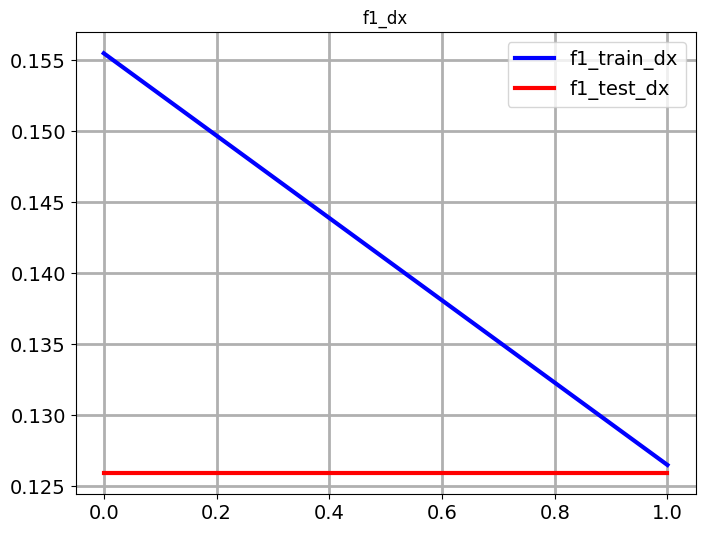

In [41]:
# 学習曲線 (損失関数) 診断モデル
plt.figure(figsize=(8,6))
plt.plot(loss_list_dx,label='train_dx', lw=3, c='b')
plt.plot(loss_list_test_dx,label='test_dx', lw=3, c='r')
plt.title('Loss_dx')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

# 学習曲線 (accuracy)
plt.figure(figsize=(8,6))
plt.plot(acc_dx,label='acc_train_dx', lw=3, c='b')
plt.plot(acc_test_dx,label='acc_test_dx', lw=3, c='r')
plt.title('accuracy_dx')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

# 学習曲線 (f1)
plt.figure(figsize=(8,6))
plt.plot(f1s_dx,label='f1_train_dx', lw=3, c='b')
plt.plot(f1s_test_dx,label='f1_test_dx', lw=3, c='r')
plt.title('f1_dx')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

Confusion matrix, without normalization
[[ 0  0  0  0  1]
 [ 0  0  0  0  5]
 [ 0  0  0  0 18]
 [ 0  0  0  0 16]
 [ 0  0  0  0 34]]


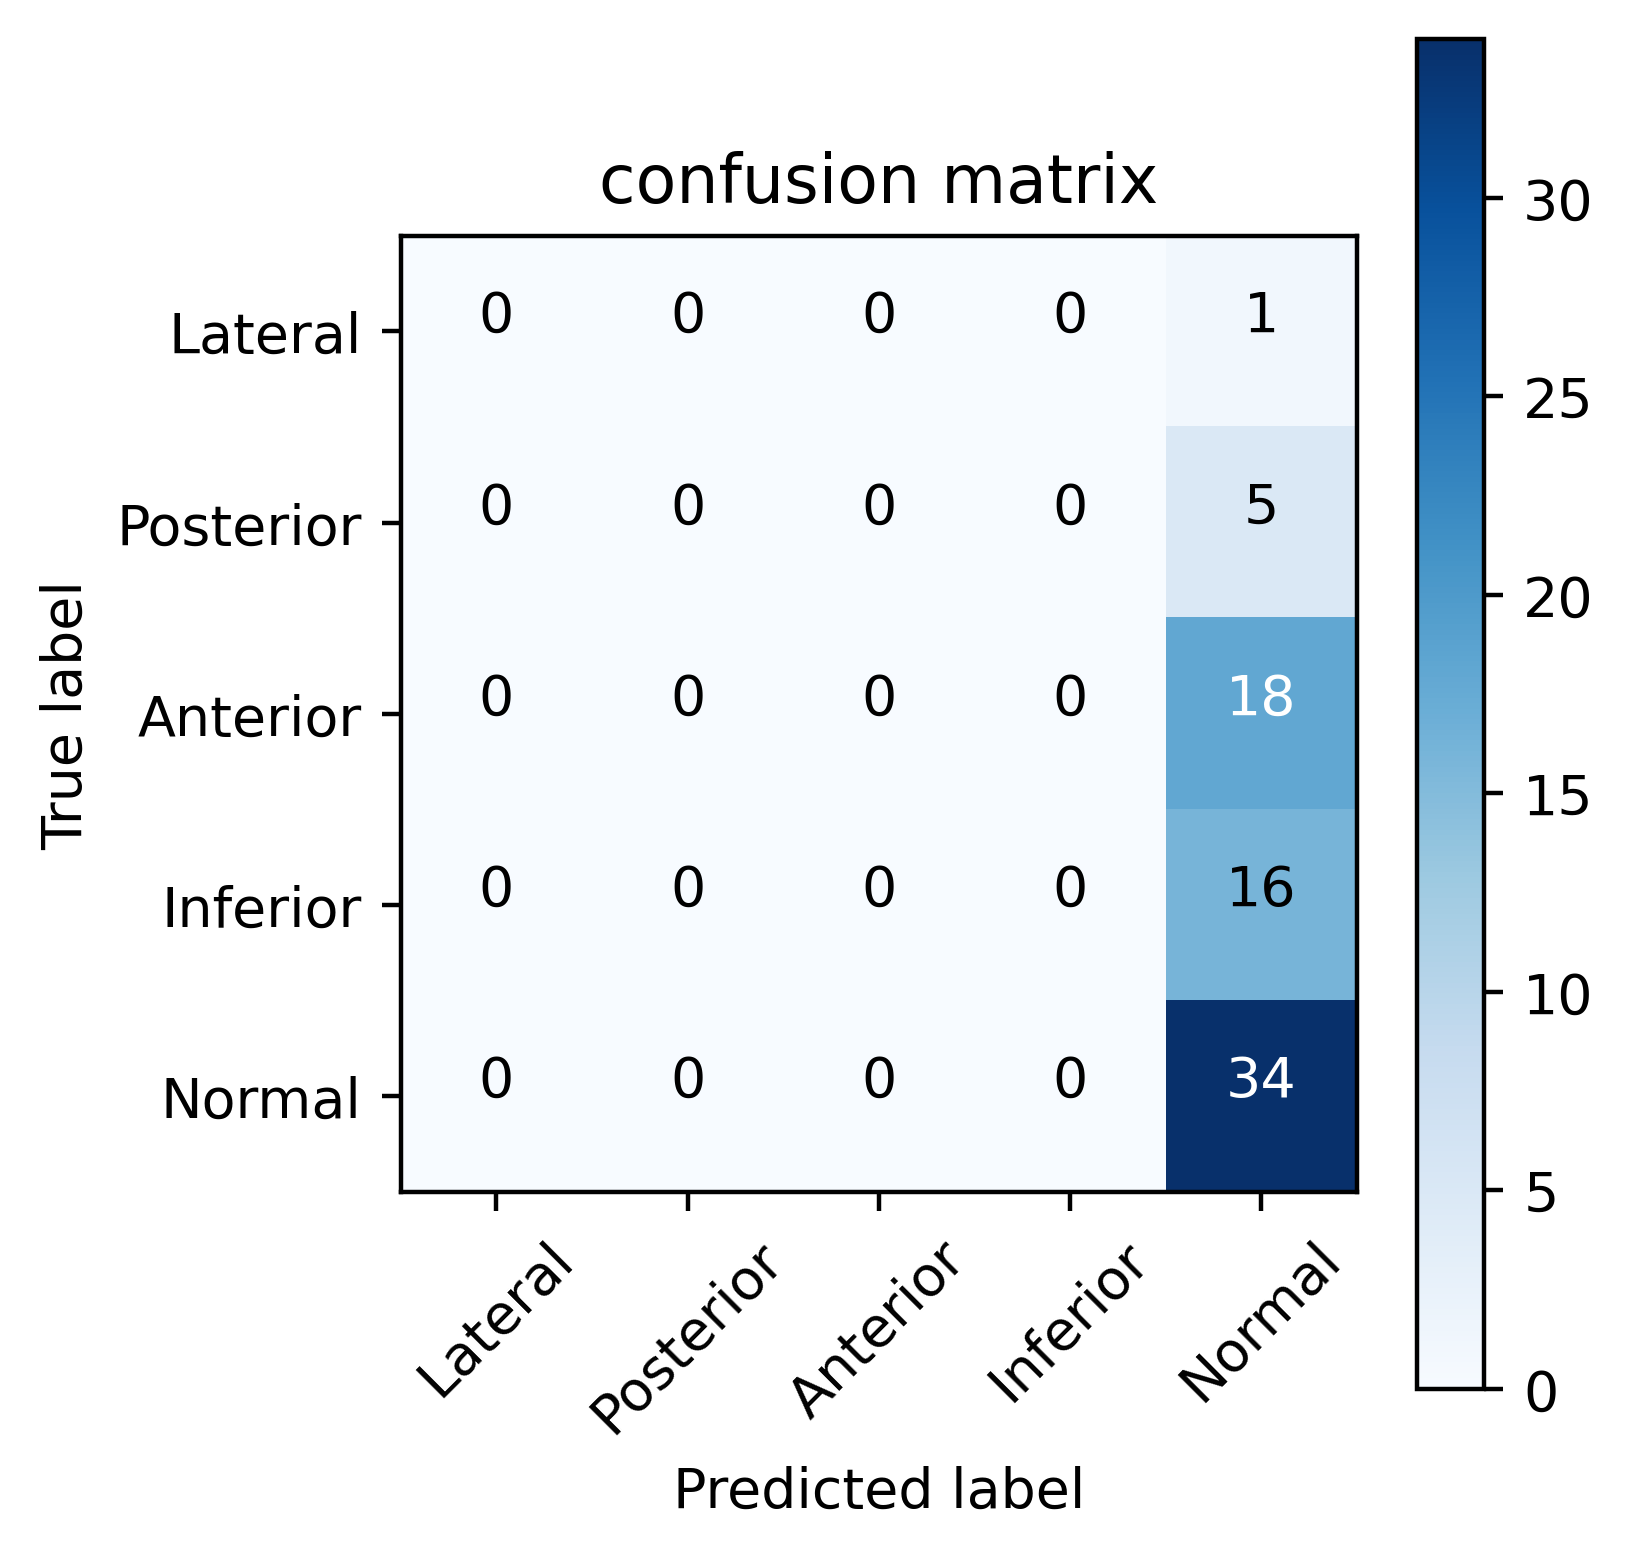

In [42]:
labels_dx=[0,1,2,3,4]
label2_dx=['Lateral','Posterior', 'Anterior', 'Inferior', 'Normal']
cnf_matrix=confusion_matrix(label_dx,pred_dx,labels=labels_dx)
title="confusion matrix"
plt.figure(figsize=(4,4),dpi=400)
plot_confusion_matrix(cnf_matrix, classes=label2_dx,title=title)
plt.show()

In [43]:
# モデルのインスタンスを作成
model_np = CNNModel().to(device)

model_np = nn.Sequential(
    model_np,
    MeanLayer()
)

print(model_np)

Sequential(
  (0): CNNModel(
    (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (gap): AdaptiveAvgPool2d(output_size=1)
    (faltten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=16, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=12, bias=True)
  )
  (1): MeanLayer()
)


In [44]:
# 診断 (事前学習なし)

# 損失関数
criterion = nn.CrossEntropyLoss()


# 最適化アルゴリズム
optimizer = optim.Adam(model_np.parameters(), lr=0.0001)
bestscore_np = 1000.0
loss_list_np,loss_list_test_np = [], []
f1s_np, f1s_test_np = [],[]
acc_np, acc_test_np = [], []

num_epochs_np = 2

# モデル訓練　5クラス分類

for epoch in range(num_epochs_np):
    model_np.train()
    running_loss_np = 0.0
    preds_np, label_np = [], []
    running_loss_np, running_loss_test_np = 0.0, 0.0
    preds_test_np,label_test_np = [], []

    for ecg_image, labels, label_lead, patients, num_leads in train_dataloader:
        image = ecg_image.reshape(-1, 3, 112, 224).to(device)
        labels = labels.reshape(-1).to(device)  # ラベルを1次元に変形
        labels = labels.to(torch.long)  # CrossEntropyLossではクラスのインデックスはlong型である必要がある

        optimizer.zero_grad()  # 勾配を初期化

        outputs = model_np(image).to(torch.float64)  # モデルの出力を計算

        prob, pred = torch.max(outputs, 1)
        preds_np.extend(pred.tolist())
        label_np.extend(labels.tolist())

        loss = criterion(outputs, labels)  # 損失を計算（CrossEntropyLossの引数は予測とラベル）
        loss.backward()  # 勾配を計算
        optimizer.step()  # パラメータを更新

        running_loss_np += loss.item()

    for ecg_image,labels,label_lead,patients,num_leads in test_dataloader:
        image =ecg_image.reshape(-1,3,112,224).to(device)
        labels = labels.reshape(-1).to(device)

        outputs = model_np(image)  # モデルの出力を計算
        outputs = outputs.to(torch.float64)
        prob, pred=torch.max(outputs,1)
        preds_test_np.extend(pred.tolist())
        label_test_np.extend(labels.tolist())
        
        #print(outputs)
        loss = criterion(outputs, labels)  # 損失を計算

        running_loss_test_np += loss.item()
    
    score_np = running_loss_test_np/len(test_dataloader)
    if score_np < bestscore_np:
        bestscore_np = score_np
        torch.save(model_np.state_dict(), '/root/notebooks/sample/models/bestmodel_np.pth')
        print('best score_np!!')
    loss_list_np.append(running_loss_np/len(train_dataloader))
    loss_list_test_np.append(running_loss_test_np/len(test_dataloader))
    f1_np = f1_score(preds_np,label_np,average='macro')
    f1_test_np = f1_score(preds_test_np,label_test_np,average='macro')
    f1s_np.append(f1_np)
    f1s_test_np.append(f1_test_np)
    accuracy_np = accuracy_score(preds_np,label_np)
    accuracy_test_np = accuracy_score(preds_test_np,label_test_np)
    acc_np.append(accuracy_np)
    acc_test_np.append(accuracy_test_np)

    # 1エポック終了時の損失を表示
    print(f"Epoch [{epoch+1}/{num_epochs_np}] Train-Loss: {running_loss_np/len(train_dataloader)} Test-Loss: {running_loss_test_np/len(train_dataloader)} Train-f1: {f1_np} Test-f1: {f1_test_np} Train-acc: {accuracy_np} Test-acc: {accuracy_test_np}")

best score_np!!
Epoch [1/2] Train-Loss: 2.4498772770996755 Test-Loss: 0.6062028547622821 Train-f1: 0.0 Test-f1: 0.008333333333333333 Train-acc: 0.0 Test-acc: 0.013513513513513514
best score_np!!
Epoch [2/2] Train-Loss: 2.2204366822403396 Test-Loss: 0.48049485031997163 Train-f1: 0.13712839974699556 Test-f1: 0.07111111111111111 Train-acc: 0.3945578231292517 Test-acc: 0.21621621621621623


In [45]:
# モデル評価 ５クラス診断(事前学習なし)
pred_np,label_np = [],[]
model_np.load_state_dict(torch.load('/root/notebooks/sample/models/bestmodel_np.pth'))
model_np.eval()

for ecg_image,labels,label_lead,patients,num_leads in test_dataloader:
    image =ecg_image.reshape(-1,3,112,224).to(device)
    labels = labels.reshape(-1).to(device)
    label_np.extend(labels.tolist())
    outputs = model_np(image)  # モデルの出力を計算
    prob_np, preds_np=torch.max(outputs,1)
    pred_np.extend(preds_np.tolist())
    f1_test_np = f1_score(preds_np.tolist(),labels.tolist(),average='macro')
    accuracy_test_np = accuracy_score(preds_test_np,label_test_np)
    loss = criterion(outputs, labels)  # 損失を計算

    running_loss_test_np += loss.item()


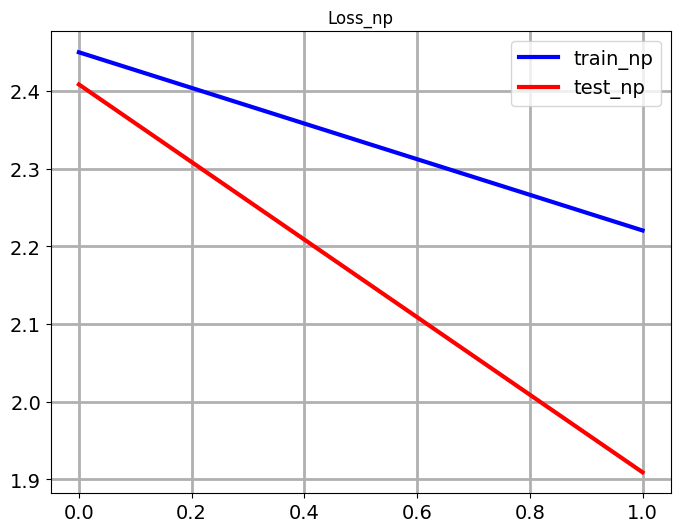

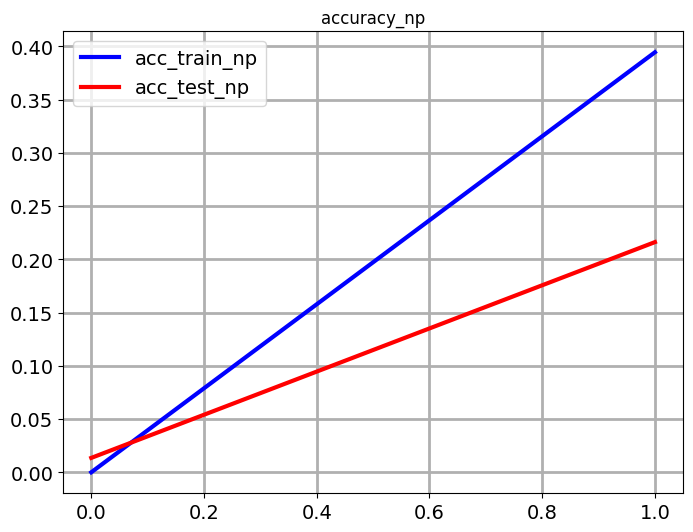

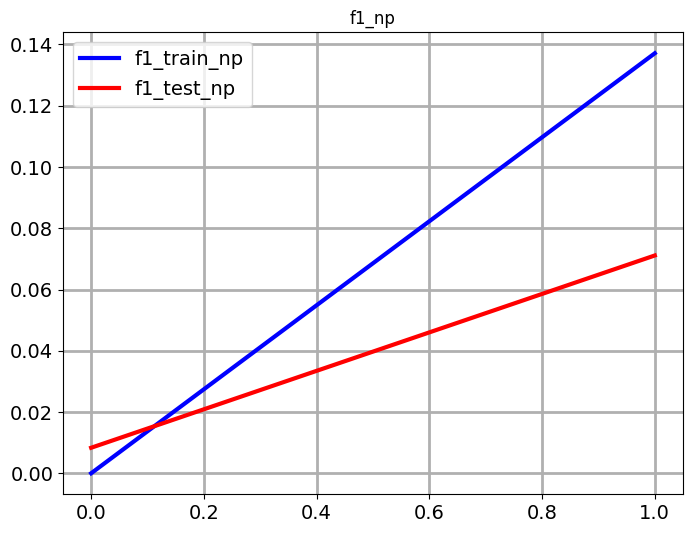

In [46]:
# 学習曲線 (損失関数) 事前学習
plt.figure(figsize=(8,6))
plt.plot(loss_list_np,label='train_np', lw=3, c='b')
plt.plot(loss_list_test_np,label='test_np', lw=3, c='r')
plt.title('Loss_np')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

# 学習曲線 (accuracy)
plt.figure(figsize=(8,6))
plt.plot(acc_np,label='acc_train_np', lw=3, c='b')
plt.plot(acc_test_np,label='acc_test_np', lw=3, c='r')
plt.title('accuracy_np')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

# 学習曲線 (F1)
plt.figure(figsize=(8,6))
plt.plot(f1s_np,label='f1_train_np', lw=3, c='b')
plt.plot(f1s_test_np,label='f1_test_np', lw=3, c='r')
plt.title('f1_np')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

Confusion matrix, without normalization
[[ 0  0  0  1  0]
 [ 0  0  0  5  0]
 [ 0  0  0 18  0]
 [ 0  0  0 16  0]
 [ 0  0  0 34  0]]


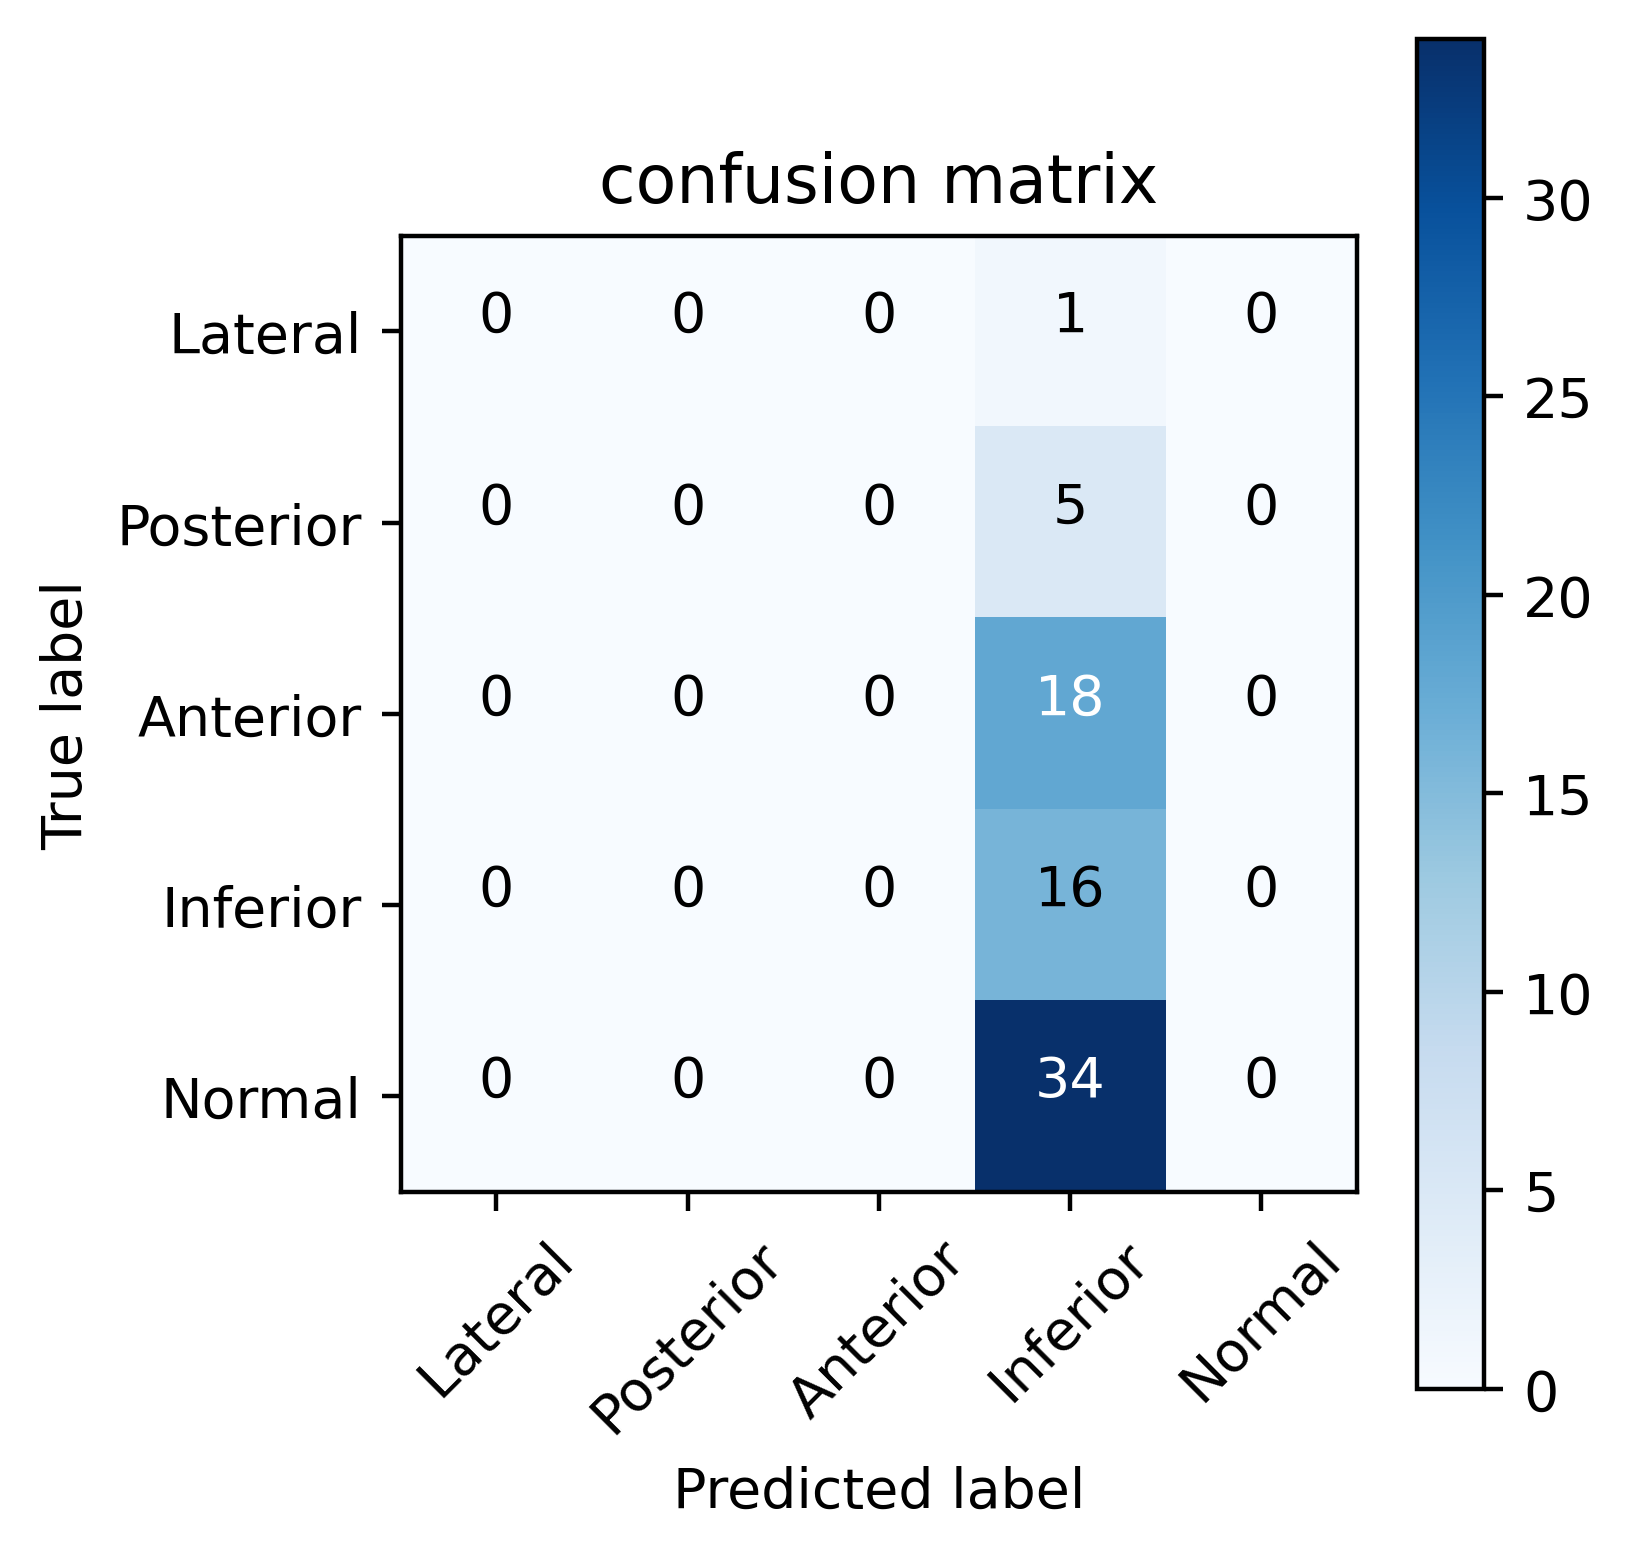

In [47]:
labels_np=[0,1,2,3,4]
label2_np=['Lateral','Posterior', 'Anterior', 'Inferior', 'Normal']
cnf_matrix=confusion_matrix(label_np,pred_np,labels=labels_np)
title="confusion matrix"
plt.figure(figsize=(4,4),dpi=400)
plot_confusion_matrix(cnf_matrix, classes=label2_np,title=title)
plt.show()